### Project 7 : Passenger Satisfaction on SBB (Swiss Federal Railways)

    1. Define a scientific question (e.g. are women better in math?)
     
    2. Simulator. What are the dependencies? How can we modify it so we get different answers? (e.g in one simulator math ability is independent of gender; in another, it depends on educational stimulus, which depends on gender).

    3. Data sources, if any. Data collection methodology, if any. (Otherwise rely on the simulation)
    
    4. Pipeline. How do you process data reliably?
    
    5. Methodology. What machine learning / statistical methods are you using to answer the question? How do you justify them?
    
    6. Summary results: plots, graphs, tables, that can help you answer the question you are interested in.
    
    7. Conclusion based on your results. Can you answer the question? If not, why not?


### Sources intéressantes

- Influence du genre sur le salaire: https://www.ebg.admin.ch/fr/les-raisons-des-ecarts-salariaux-entre-les-femmes-et-les-hommes

- Salaires Moyens : https://www.bfs.admin.ch/bfs/fr/home/statistiques/travail-remuneration/salaires-revenus-cout-travail.html
- Durée : https://www.bfs.admin.ch/bfs/fr/home/statistiques/mobilite-transports/transport-personnes/comportements-transports/distance-duree-jour-deplacements.html
- Fréquence : https://www.bav.admin.ch/bav/fr/home/modes-de-transport/chemin-de-fer/transport-des-voyageurs.html
- Propreté :https://www.bav.admin.ch/bav/fr/home/themes-generaux/trv/systeme-de-mesure-de-la-qualite.html (je trouve inutile de l'ajouter, car la proprété est globalement très bonne en Suisse)


### TODO:
 - Changer les relations entre les variables afin d'avoir des résultats différents (Simplifier mon implémentation)
 - Faire un graph des changements
 - Essayer Knn et MLP

# **But :**
Notre objectif est de développer un modèle de classification qui prédit si un passager est satisfait ou insatisfait, en fonction de différents critères liés aux services des CFF.

# **Variables choisies :**
Les variables que nous avons sélectionnées incluent des aspects comme :

* Surpopulation (Overcrowding)  
* Prix des billets (Price)
* Ponctualité (Punctuality)
* Durée du voyage (Duration)
* Fréquence des trajets (Frequency)
* Revenu (Income)
* Possession d’une voiture (Has Car)
* Genre (Gender)
* Nombre de jours de télétravail (Remote Working Days)
* Âge (Age)

### Graph dependecies

In [1]:
import graphviz

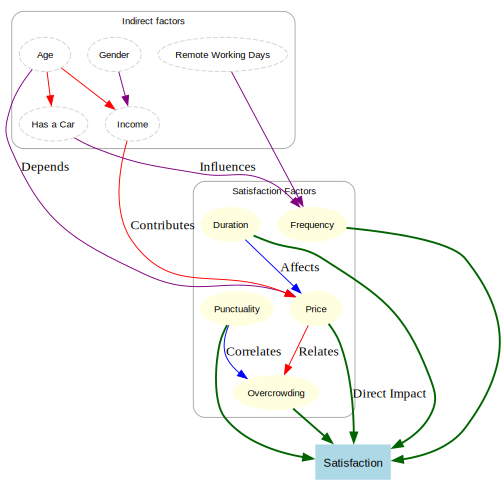

In [2]:
from graphviz import Digraph

# Create a Digraph object
dot = Digraph('Passenger Satisfaction')
dot.attr(rankdir='TB', size='7,9')  # Vertical layout, larger canvas for hierarchy

# Define node styles
dot.attr('node', shape='box', style='filled', color='lightblue', fontname='Helvetica', fontsize='12')
dot.node('S', 'Satisfaction')

# Factors directly affecting satisfaction
dot.attr('node', shape='ellipse', style='filled', color='lightyellow', fontname='Helvetica', fontsize='10')
dot.node('P', 'Price')
dot.node('U', 'Punctuality')
dot.node('D', 'Duration')
dot.node('F', 'Frequency')
dot.node('O', 'Overcrowding')

# Indirect factors
dot.attr('node', shape='ellipse', style='dashed', color='lightgray', fontname='Helvetica', fontsize='10')
dot.node('A', 'Age')
dot.node('G', 'Gender')
dot.node('I', 'Income')
dot.node('R', 'Remote Working Days')
dot.node('C', 'Has a Car')

# Organize clusters
with dot.subgraph(name='cluster_independent') as c:
    c.attr(label='Indirect factors', style='rounded', color='darkgray', fontname='Helvetica', fontsize='10')
    c.node('A')
    c.node('G')
    c.node('I')
    c.node('R')
    c.node('C')

with dot.subgraph(name='cluster_factors') as c:
    c.attr(label='Satisfaction Factors', style='rounded', color='darkgray', fontname='Helvetica', fontsize='10')
    c.node('P')
    c.node('U')
    c.node('D')
    c.node('F')
    c.node('O')

# Add edges for satisfaction factors
dot.edge('P', 'S', color='darkgreen', penwidth='2', label='Direct Impact')
dot.edge('U', 'S', color='darkgreen', penwidth='2')
dot.edge('D', 'S', color='darkgreen', penwidth='2')
dot.edge('F', 'S', color='darkgreen', penwidth='2')
dot.edge('O', 'S', color='darkgreen', penwidth='2')

# Relationships among features
dot.edge('D', 'P', color='blue', label='Affects')
dot.edge('U', 'O', color='blue', label='Correlates')

dot.edge('A', 'P', color='purple', label='Depends')
dot.edge('C', 'F', color='purple', label='Influences')
dot.edge('G', 'I', color='purple')
dot.edge('R', 'F', color='purple')

dot.edge('I', 'P', color='red', label='Contributes')
dot.edge('A', 'I', color='red')
dot.edge('A', 'C', color='red')
dot.edge('P', 'O', color='red', label='Relates')

# Render the graph
dot

### Data generation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GenerativeModel import *

In [4]:
# Generation of synthetic data
np.random.seed(1)
gen = ComplexDependentSatisfaction(100000)

data = gen.df

data.head()

,Age,Gender,Income,Remote Working Days,Has Car,Price,Punctuality,Duration,Frequency,Overcrowding,Satisfaction
0,44,F,84000,3,no,2,4,3,2,4,0
1,58,M,109000,4,yes,5,5,5,3,4,1
2,47,M,84000,1,yes,2,3,4,2,5,0
3,20,F,60680,0,yes,3,4,4,2,3,0
4,18,M,1000,0,yes,2,5,5,1,5,0


[]

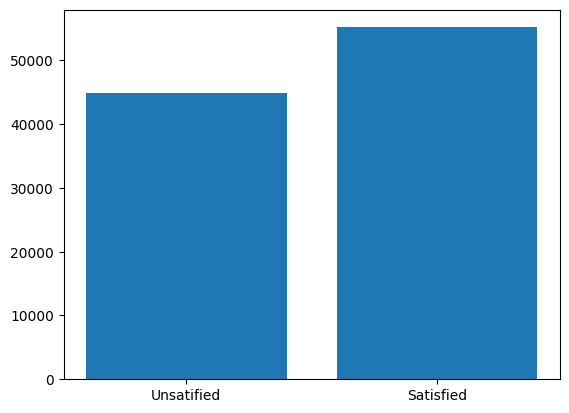

In [5]:
satis = data['Satisfaction'].value_counts().to_numpy()
satis = np.sort(satis)
plt.bar(["Unsatified", "Satisfied"], satis)
plt.plot()

### Simple Pipeline

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [7]:
numeric_features = [ "Age", "Income", "Remote Working Days",
                    "Price", "Punctuality", "Duration", "Frequency",
                    "Overcrowding"]
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)

categorical_features = ["Has Car", "Gender"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder())
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

In [9]:
def SimplePipeline(simulator, data_size):
    np.random.seed(1)
    gen = simulator(data_size)
    data = gen.df
    
    X = data.copy().drop(['Satisfaction'], axis=1)
    y = data['Satisfaction']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    def my_pipeline(model, preprocessor):
        clf = Pipeline(
        steps=[("preprocessor", preprocessor),
               ("classifier", model)]
        )
        clf.fit(X_train, y_train)
        return clf.score(X_test, y_test)

    score_random_forest = my_pipeline(RandomForestClassifier(), preprocessor)
    score_logistic = my_pipeline(LogisticRegression(), preprocessor)
    score_perceptron = my_pipeline(Perceptron(), preprocessor)
    score_knn = my_pipeline(KNeighborsClassifier(), preprocessor)
    
    print(f"Simulator = {gen}, Size of data = {data_size}")
    print(f"Accuracy score for Random Forest Classifier: {score_random_forest:.4f}")
    print(f"Accuracy score for Logistic Regression: {score_logistic:.4f}")
    print(f"Accuracy score for Single Layer Perceptron: {score_perceptron:.4f}")
    print(f"Accuracy score for KNeighborsClassifier: {score_knn:.4f}")

In [10]:
SimplePipeline(ComplexDependentSatisfaction, 1000)

Simulator = ComplexDependentSatisfaction, Size of data = 1000
Accuracy score for Random Forest Classifier: 0.6333
Accuracy score for Logistic Regression: 0.6515
Accuracy score for Single Layer Perceptron: 0.6152
Accuracy score for KNeighborsClassifier: 0.6000


In [11]:
SimplePipeline(ImpactOnOvercrowding, 1000)

Simulator = ImpactOnOvercrowding, Size of data = 1000
Accuracy score for Random Forest Classifier: 0.5939
Accuracy score for Logistic Regression: 0.6091
Accuracy score for Single Layer Perceptron: 0.5455
Accuracy score for KNeighborsClassifier: 0.5879


### Feature selection

#### Why feature selection ?

Because we need to be certain that the results match the simulation. So we do this principally to check if our the results make sense in regard of the simulation. 

In [12]:
from GenerativeModel import ComplexDependentSatisfaction

In [13]:
# Generation of synthetic data
np.random.seed(1)
gen = ComplexDependentSatisfaction(1000)
data = gen.df
data.head()

,Age,Gender,Income,Remote Working Days,Has Car,Price,Punctuality,Duration,Frequency,Overcrowding,Satisfaction
0,45,F,84000,2,yes,2,4,3,3,2,1
1,26,F,164000,2,no,5,5,5,2,3,1
2,56,M,200000,0,yes,4,5,3,1,1,0
3,20,F,60680,4,no,2,5,2,5,5,0
4,58,M,84000,2,yes,5,4,2,4,3,1


[]

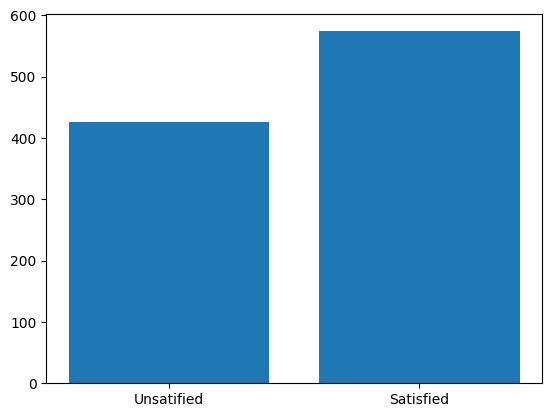

In [14]:
satis = data['Satisfaction'].value_counts().to_numpy()
satis = np.sort(satis)
plt.bar(["Unsatified", "Satisfied"], satis)
plt.plot()

In [15]:
data['Gender'] = data['Gender'].map({'M': 1, 'F': 0})
data['Has Car'] = data['Has Car'].map({'yes': 1, 'no': 0})
data.head()

,Age,Gender,Income,Remote Working Days,Has Car,Price,Punctuality,Duration,Frequency,Overcrowding,Satisfaction
0,45,0,84000,2,1,2,4,3,3,2,1
1,26,0,164000,2,0,5,5,5,2,3,1
2,56,1,200000,0,1,4,5,3,1,1,0
3,20,0,60680,4,0,2,5,2,5,5,0
4,58,1,84000,2,1,5,4,2,4,3,1


In [16]:
# Filter method
correlations = data.corr()['Satisfaction'].abs().sort_values(ascending=False)
print('correlation:',correlations)

correlation: Satisfaction           1.000000
Punctuality            0.259190
Overcrowding           0.221719
Frequency              0.178735
Has Car                0.043892
Price                  0.034611
Age                    0.027998
Gender                 0.014530
Duration               0.011862
Income                 0.010151
Remote Working Days    0.004051
Name: Satisfaction, dtype: float64


In [17]:
# RFE
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

def RFE_model(data):
    # Define the model using linear regression
    model = LogisticRegression()

    # Define RFE with the model and specify the number of features to select
    rfe = RFE(model, n_features_to_select=5)

    # Separate features and target variable
    X = data.drop(columns=['Satisfaction'])
    y = data['Satisfaction']

    scale = MinMaxScaler()
    X_minmax = scale.fit_transform(X)
    # Fit RFE to the data
    rfe.fit(X_minmax, y)

    # Get the ranking of features
    feature_ranking = pd.DataFrame({
        'feature': X.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')

    print(feature_ranking)
    return feature_ranking

In [18]:
data_size = 10000
np.random.seed(1)
gen = ComplexDependentSatisfaction(data_size)
data = gen.df
data['Gender'] = data['Gender'].map({'M': 1, 'F': 0})
data['Has Car'] = data['Has Car'].map({'yes': 1, 'no': 0})
print(f"Simulator: {gen}")
feature_ranking = RFE_model(data)

gen2 = ImpactOnOvercrowding(data_size)
data2 = gen2.df
data2['Gender'] = data2['Gender'].map({'M': 1, 'F': 0})
data2['Has Car'] = data2['Has Car'].map({'yes': 1, 'no': 0})
print(f"Simulator: {gen2}")
feature_ranking = RFE_model(data2)


Simulator: ComplexDependentSatisfaction
               feature  rank
5                Price     1
6          Punctuality     1
7             Duration     1
8            Frequency     1
9         Overcrowding     1
1               Gender     2
3  Remote Working Days     3
2               Income     4
0                  Age     5
4              Has Car     6
Simulator: ImpactOnOvercrowding
                feature  rank
6                 Price     1
7           Punctuality     1
8              Duration     1
9             Frequency     1
10         Overcrowding     1
5           First-Class     2
2                Income     3
3   Remote Working Days     4
1                Gender     5
0                   Age     6
4               Has Car     7


In [19]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

X = data.drop(columns=['Satisfaction'])
y = data['Satisfaction']

scale = MinMaxScaler()
X_minmax = scale.fit_transform(X)
# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_minmax, y)

# Get feature importances
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importances)

               feature  importance
0                  Age    0.270022
2               Income    0.124520
3  Remote Working Days    0.098952
7             Duration    0.095428
9         Overcrowding    0.091932
5                Price    0.089409
8            Frequency    0.082844
6          Punctuality    0.074318
1               Gender    0.041830
4              Has Car    0.030745


In [20]:
# comparing the different models

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scale = MinMaxScaler()
X_train_minmax = scale.fit_transform(X_train)
X_test_minmax = scale.fit_transform(X_test)

# Model without feature selection
model_all_features = LogisticRegression(max_iter=200)
model_all_features.fit(X_train_minmax, y_train)
predictions_all = model_all_features.predict(X_test_minmax)
accuracy_all = accuracy_score(y_test, predictions_all)
print(f'Accuracy without feature selection: {accuracy_all:.6f}')

# Model with selected features (top 5 from RFE)
selected_features = feature_ranking[feature_ranking['rank'] == 1]['feature']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected_minmax = scale.fit_transform(X_train_selected)
X_test_selected_minmax = scale.fit_transform(X_test_selected)

model_selected_features = LogisticRegression(max_iter=200)
model_selected_features.fit(X_train_selected_minmax, y_train)
predictions_selected = model_selected_features.predict(X_test_selected_minmax)
accuracy_selected = accuracy_score(y_test, predictions_selected)

print(f'Accuracy with feature selection (RFE): {accuracy_selected:.6f}')

# Model with selected features (correleted filter > 0.4)
X_train_selected = X_train.loc[:,["Price", "Overcrowding"]]
X_test_selected = X_test.loc[:,["Price", "Overcrowding"]]

model_selected_features = LogisticRegression(max_iter=200)
model_selected_features.fit(X_train_selected_minmax, y_train)
predictions_selected = model_selected_features.predict(X_test_selected_minmax)
accuracy_selected = accuracy_score(y_test, predictions_selected)

print(f'Accuracy with feature selection (Filter): {accuracy_selected:.6f}')

# Model with selected features (Random Forest)
selected_features = importances[importances['importance'] > 0.1]['feature']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected_minmax = scale.fit_transform(X_train_selected)
X_test_selected_minmax = scale.fit_transform(X_test_selected)

model_selected_features = LogisticRegression(max_iter=200)
model_selected_features.fit(X_train_selected_minmax, y_train)
predictions_selected = model_selected_features.predict(X_test_selected_minmax)
accuracy_selected = accuracy_score(y_test, predictions_selected)

print(f'Accuracy with feature selection (Random Forest): {accuracy_selected:.6f}')

Accuracy without feature selection: 0.621667
Accuracy with feature selection (RFE): 0.620000
Accuracy with feature selection (Filter): 0.620000
Accuracy with feature selection (Random Forest): 0.553000


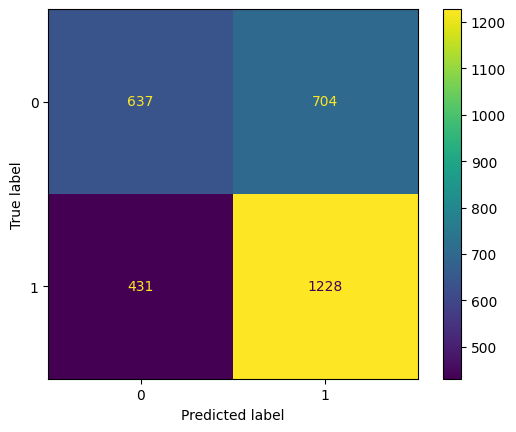

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions_all, labels=model_all_features.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_all_features.classes_)
disp.plot()
plt.show()

In [22]:
accuracies = np.zeros(X.shape[1])
for i in range (1, X.shape[1] + 1):
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_minmax, y)

    # Get the ranking of features
    feature_ranking = pd.DataFrame({
        'feature': X.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')
    # top i from RFE
    selected_features = feature_ranking[feature_ranking['rank'] == 1]['feature']
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    X_train_selected_minmax = scale.fit_transform(X_train_selected)
    X_test_selected_minmax = scale.fit_transform(X_test_selected)

    model_selected_features = LogisticRegression(max_iter=200)
    model_selected_features.fit(X_train_selected_minmax, y_train)
    predictions_selected = model_selected_features.predict(X_test_selected_minmax)
    accuracies[i - 1] = accuracy_score(y_test, predictions_selected)

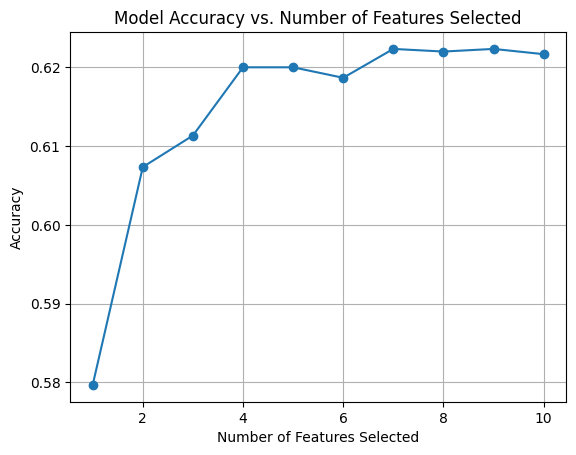

In [23]:
# Plot accuracy vs. number of features
plt.plot(np.arange(1, X.shape[1] + 1), accuracies, marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Number of Features Selected")
plt.grid()
plt.show()

In [24]:
i = np.argmax(accuracies)
print(f"Max accuracy is {accuracies[i]}, with {i + 1} features selected !")

Max accuracy is 0.6223333333333333, with 7 features selected !


# J'aime pas trop

### Feature Importance Across Selection Methods

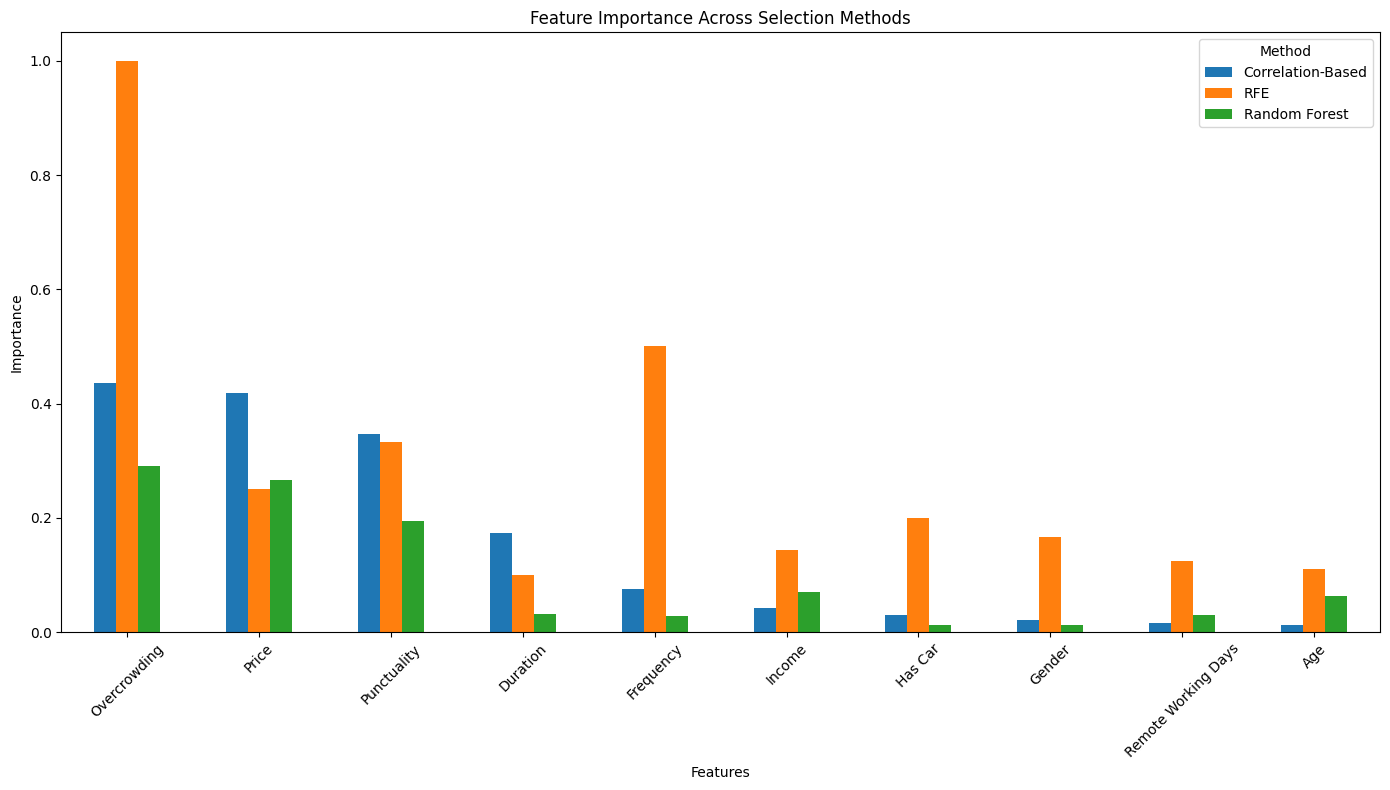

In [25]:
# New extracted features and their importance values
features = [
    "Overcrowding", "Price", "Punctuality", "Duration", "Frequency",
    "Income", "Has Car", "Gender", "Remote Working Days", "Age"
]

# Correlation-Based Importance
correlation_importance = [
    0.435196, 0.418901, 0.346210, 0.174066, 0.075954,
    0.041293, 0.029084, 0.021831, 0.015452, 0.012124
]

# RFE-Based Importance (inverse of rank for better visualization)
rfe_ranking = [1,4,3,10,2,7,5,6,8,9]
rfe_importance = [1 / rank if rank != 0 else 0 for rank in rfe_ranking]

# Random Forest-Based Importance
random_forest_importance = [
    0.290783, 0.266373, 0.194532, 0.032256, 0.028560,
    0.070537, 0.011941, 0.012852, 0.029607, 0.062559
]

# DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Correlation-Based': correlation_importance,
    'RFE': rfe_importance,
    'Random Forest': random_forest_importance
})

# Bar plots for feature importance changes
importance_df.set_index('Feature').plot(kind='bar', figsize=(14, 8))
plt.title("Feature Importance Across Selection Methods")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.legend(title="Method")
plt.tight_layout()
plt.show()

### Tree based methods

In [26]:
from GenerativeModel import ComplexDependentSatisfaction
# Generation of synthetic data
np.random.seed(1)
gen = ComplexDependentSatisfaction(100)
data = gen.df
data['Gender'] = data['Gender'].map({'M': 1, 'F': 0})
data['Has Car'] = data['Has Car'].map({'yes': 1, 'no': 0})
data.head()

,Age,Gender,Income,Remote Working Days,Has Car,Price,Punctuality,Duration,Frequency,Overcrowding,Satisfaction
0,47,1,109000,0,1,5,4,5,3,3,0
1,48,1,84000,0,0,1,5,3,4,3,0
2,21,1,74000,2,0,3,5,5,4,5,0
3,66,0,109000,3,0,4,4,3,3,2,1
4,46,0,109000,1,0,4,5,3,1,1,0


In [27]:
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_squared_error

X = gen.df.drop(columns=["Satisfaction"])
y = gen.df["Satisfaction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

tryhout_lenght = 10
lr_multiplier = tryhout_lenght / (tryhout_lenght * 10)

decision_tree_acc = np.zeros(tryhout_lenght)
random_forest_acc = np.zeros(tryhout_lenght)
ada_boost_acc = np.zeros(tryhout_lenght)

decision_tree_log_loss = np.zeros(tryhout_lenght)
random_forest_log_loss = np.zeros(tryhout_lenght)
ada_boost_log_loss = np.zeros(tryhout_lenght)


for i in range(1, tryhout_lenght + 1):
    decision_tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0)
    random_forest_clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=i, random_state=0)
    ada_boost_clf = AdaBoostClassifier(n_estimators=100, learning_rate=i * lr_multiplier, algorithm='SAMME', random_state=0)

    decision_tree_clf.fit(X_train, y_train)
    random_forest_clf.fit(X_train, y_train)
    ada_boost_clf.fit(X_train, y_train)

    decision_tree_y_pred = decision_tree_clf.predict(X_test)
    random_forest_y_pred = random_forest_clf.predict(X_test)
    ada_boost_y_pred = ada_boost_clf.predict(X_test)

    decision_tree_y_proba = decision_tree_clf.predict_proba(X_test)
    random_forest_y_proba = random_forest_clf.predict_proba(X_test)
    ada_boost_y_proba = ada_boost_clf.predict_proba(X_test)

    decision_tree_acc[i - 1] = accuracy_score(y_test, decision_tree_y_pred)
    random_forest_acc[i - 1] = accuracy_score(y_test, random_forest_y_pred)
    ada_boost_acc[i - 1] = accuracy_score(y_test, ada_boost_y_pred)

    decision_tree_log_loss[i - 1] = log_loss(y_test, decision_tree_y_proba)
    random_forest_log_loss[i - 1] = log_loss(y_test, random_forest_y_proba)
    ada_boost_log_loss[i - 1] = log_loss(y_test, ada_boost_y_proba)

best_dt_index = np.argmax(decision_tree_acc)
best_rf_index = np.argmax(random_forest_acc)
best_ada_index = np.argmax(ada_boost_acc)

print(f"best accuracy for Decision Tree Classifier : {decision_tree_acc[best_dt_index]}")
print(f"best accuracy for Random Forest Classifier : {random_forest_acc[best_rf_index]}")
print(f"best accuracy for Ada Boost Classifier : {ada_boost_acc[best_ada_index]}")

best accuracy for Decision Tree Classifier : 0.7
best accuracy for Random Forest Classifier : 0.7666666666666667
best accuracy for Ada Boost Classifier : 0.7666666666666667


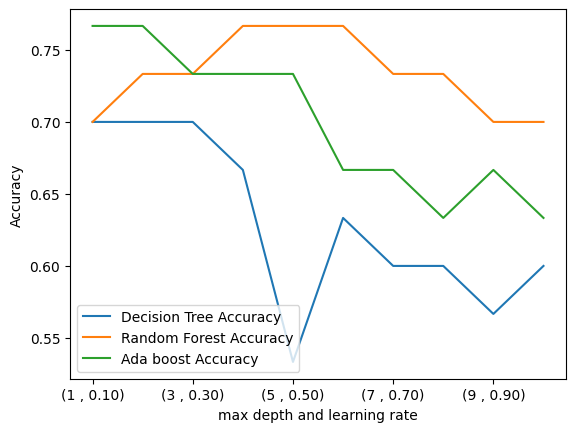

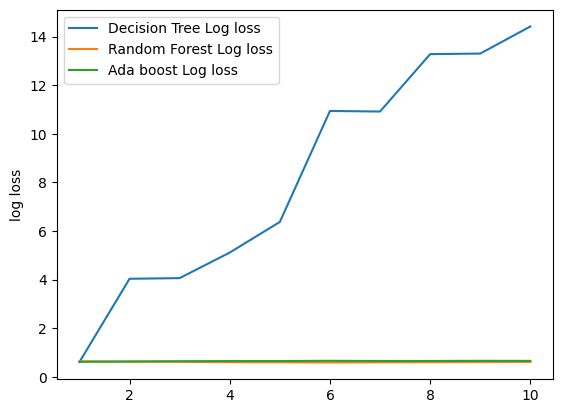

In [28]:
x_axis = np.arange(1, tryhout_lenght + 1, 1)
x_axis_l = np.arange(1, tryhout_lenght + 1, 2)


plt.plot(x_axis, decision_tree_acc)
plt.plot(x_axis, random_forest_acc)
plt.plot(x_axis, ada_boost_acc)

plt.xticks(ticks=x_axis_l, labels=[f"({i} , {i*lr_multiplier:.2f})" for i in x_axis_l])
plt.legend(["Decision Tree Accuracy", "Random Forest Accuracy", "Ada boost Accuracy"])
plt.xlabel("max depth and learning rate")
plt.ylabel("Accuracy")
plt.show()

plt.plot(x_axis, decision_tree_log_loss)
plt.plot(x_axis, random_forest_log_loss)
plt.plot(x_axis, ada_boost_log_loss)
plt.ylabel("log loss")
plt.legend(["Decision Tree Log loss", "Random Forest Log loss", "Ada boost Log loss"])
plt.show()